In [11]:
import botorch
import torch
import matlab.engine
import io
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
sys.path.append(os.path.abspath('..'))

eng = matlab.engine.start_matlab()
eng.cd(r'./MPC_BO_Thickness_ver7.0_CASE3', nargout=0)

In [2]:
# Now, the second return is 1 if succeed, 0 otherwise
def problem_wrapper(dA=1.5):
    def problem(Tref, Iref, Aref1, Aref2, Aref3):
        res = eng.RT_control_return(Tref, Iref, matlab.double([[Aref1],[Aref2],[Aref3]]), dA, stdout=io.StringIO())
        return torch.from_numpy(np.asarray(res))
    return problem

In [3]:
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [4]:
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.transforms.outcome import Standardize
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import normalize, unnormalize
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood

from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.acquisition.objective import MCAcquisitionObjective
from botorch.optim.optimize import optimize_acqf

BATCH_SIZE = 1
NUM_RESTARTS = 256 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

bounds = torch.tensor([[35, 1500, 1.4016/2., -14.4395*2., 12.5570/2.],
                       [65, 3000, 1.4016*2., -14.4395/2., 12.5570*2.]]).to(**tkwargs)
#bounds = torch.tensor([[35, 1500, 1.4016*1.0, -14.4395*1.5, 12.5570*1.0],
#                       [65, 3000, 1.4016*1.5, -14.4395*1.0, 12.5570*1.5]]).to(**tkwargs)
standard_bounds = torch.zeros(2, bounds.shape[1], **tkwargs)
standard_bounds[1] = 1
# need to also include the bounds for the run idx
# though this is fixed during AF optimization
bounds = torch.cat((bounds, torch.tensor([[0],[100]]).to(**tkwargs)), dim=-1)
bounds[1, -1] = 1.
# we do not normalized the time (index)
standard_bounds = torch.cat((standard_bounds, torch.tensor([[0],[100]]).to(**tkwargs)), dim=-1)
# extra bounds for time (index) to make the AF optimization happy


In [5]:
from custom_kernels import PosEncode
from covar_module import get_spatio_temp_kernel
NOISE_SE = torch.tensor([0.0] * 1, **tkwargs)

def generate_initial_data(problem, n=7, guaratee_feasible=True):
    # generate training data
    train_x = draw_sobol_samples(bounds=bounds[:,:-1], n=n, q=1).squeeze(1)
    train_obj_plain = torch.cat([problem(*_.tolist()).reshape(1,-1) for _ in train_x], dim=0)
    train_obj_true = train_obj_plain[..., :-1]
    train_obj = train_obj_true + torch.randn_like(train_obj_true) * NOISE_SE
    if guaratee_feasible:
        final_train_x = torch.zeros((0, train_x.shape[-1]))
        final_train_obj_true = torch.zeros((0, train_obj_true.shape[-1]))
        final_train_obj = torch.zeros_like(final_train_obj_true)
        mask = (train_obj_plain[:, -1] == 1).reshape(-1)
        final_train_x = torch.cat((final_train_x, train_x[mask, :]), dim=0)
        final_train_obj_true = torch.cat((final_train_obj_true, train_obj_true[mask, :]), dim=0)
        final_train_obj = torch.cat((final_train_obj, train_obj[mask, :]), dim=0)
        n = n-final_train_x.shape[0]
        while n:
            train_x = draw_sobol_samples(bounds=bounds[:,:-1], n=n, q=1).squeeze(1)
            train_obj_plain = torch.cat([problem(*_.tolist()).reshape(1,-1) for _ in train_x], dim=0)
            train_obj_true = train_obj_plain[..., :-1]
            train_obj = train_obj_true + torch.randn_like(train_obj_true) * NOISE_SE
            mask = (train_obj_plain[:, -1] == 1).reshape(-1)
            final_train_x = torch.cat((final_train_x, train_x[mask, :]), dim=0)
            final_train_obj_true = torch.cat((final_train_obj_true, train_obj_true[mask, :]), dim=0)
            final_train_obj = torch.cat((final_train_obj, train_obj[mask, :]), dim=0)
            n = n-train_x[mask, :].shape[0]
        return final_train_x, final_train_obj, final_train_obj_true

    return train_x, train_obj, train_obj_true


def initialize_model(train_x, 
                     train_obj, 
                     input_trans=None, 
                     input_trans_args=None,
                     type_of_forgetting='UI',
                     forgetting_factor=0.03):
    # define models for objective and constraint
    train_x = normalize(train_x, bounds)
    models = []
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i : i + 1]
        train_yvar = torch.full_like(train_y, NOISE_SE[i] ** 2)
        covar = get_spatio_temp_kernel(train_x,
                                       train_y, 
                                       type_of_forgetting=type_of_forgetting,
                                       forgetting_factor=forgetting_factor)
        if input_trans is not None:
            models.append(FixedNoiseGP(train_x,
                                       train_y, 
                                       train_yvar, 
                                       covar_module=covar,
                                       outcome_transform=Standardize(m=1), 
                                       input_transform=input_trans(**input_trans_args)))
        else:         
            models.append(FixedNoiseGP(train_x, 
                                       train_y, 
                                       train_yvar,
                                       covar_module=covar, 
                                       outcome_transform=Standardize(m=1)))
    model = models[0] # in this case it is single objective!!!
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

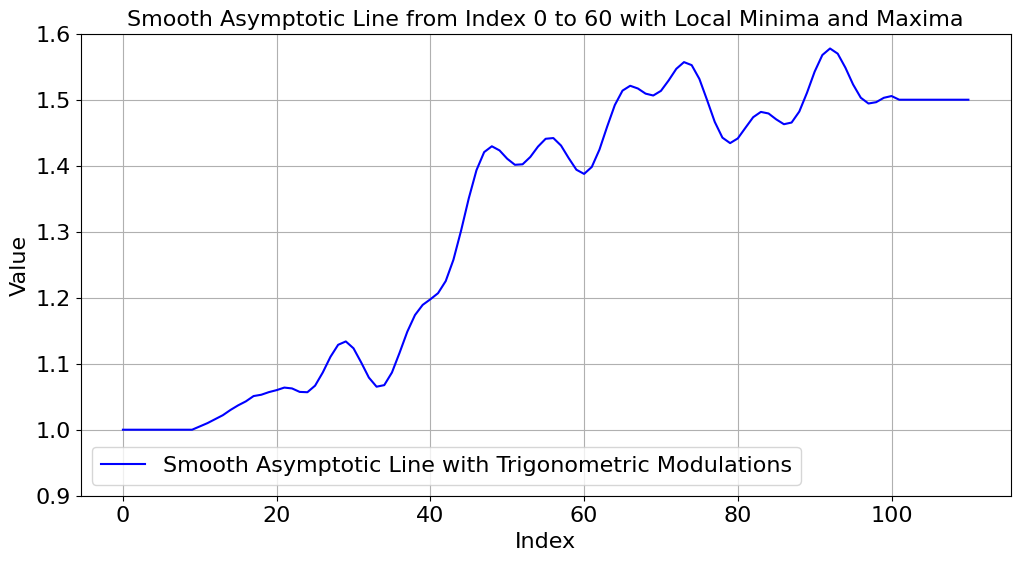

In [13]:
# Define the indices and the modified function with trigonometric functions added to create local minima and maxima
ori_indeices = np.array(range(-10, 81))
indices =ori_indeices*1.4
line = 1 + (0.5 / (1 + np.exp(-0.1 * (indices - 30)))) + 0.05 * np.sin(0.2 * indices) + 0.03 * np.cos(0.5 * indices)
line = [1.,1.,1.,1.,1.]*2 + line.tolist()+[1.5] * 10
line[10] = 1.005
line[11] = 1.01
line[12] = 1.016
line[13] = 1.022
line[14] = 1.030
line[15] = 1.037
line[16] = 1.043
line[17] = 1.051
line[18] = 1.053
line[19] = 1.057
line[20] = 1.060
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(line)), line, label='Smooth Asymptotic Line with Trigonometric Modulations', color='blue')

# Setting the limit for y-axis to make the asymptotic nature clearer
plt.ylim(0.9, 1.6)

# Annotate the asymptotic values
#plt.annotate('Asymptotic value = 1', xy=(0, 1), xytext=(5, 1.1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
#plt.annotate('Asymptotic value = 1.5', xy=(60, 1.5), xytext=(45, 1.55),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# Set the range for the x-axis
#plt.xlim(0, 81)

# Label the axes
plt.xlabel('Index')
plt.ylabel('Value')

# Add a title and a legend
plt.title('Smooth Asymptotic Line from Index 0 to 60 with Local Minima and Maxima')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


In [6]:
import pickle
with open('case3_TVBOpos_128.pkl','rb') as fp:
    RITVBO = pickle.load(fp)

In [8]:
from botorch.fit import fit_gpytorch_model
cur_model = initialize_model(RITVBO[0]['outcome_X'],RITVBO[0]["outcome_Y"],
                 PosEncode, {"positional_emb_dim": 128, "reduce_to_one": True, "tkwargs": tkwargs},
                 "UI_learning", 0.03)
fit_gpytorch_model(cur_model[0])

/Users/shaoketong/anaconda3/lib/python3.8/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/shaoketong/anaconda3/lib/python3.8/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/shaoketong/anaconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ExactMarginalLogLikelihood(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (model): FixedNoiseGP(
    (likelihood): FixedNoiseGaussianLikelihood(
      (noise_covar): FixedGaussianNoise()
    )
    (mean_module): ConstantMean()
    (covar_module): ProductKernel(
      (kernels): ModuleList(
        (0): ScaleKernel(
          (base_kernel): MaternKernel(
            (lengthscale_prior): GammaPrior()
            (raw_lengthscale_constraint): Positive()
          )
          (outputscale_prior): GammaPrior()
          (raw_outputscale_constraint): Positive()
        )
        (1): WienerKernel_learning(
          (raw_outputscale_constraint): Positive()
        )
      )
    )
    (input_transform): PosEncode(
      (positive_increase_scaler_constraint): Interval(0.000E+00, 1.000E+01)
    )
    (outcome_transform): Standardize()
  )
)

In [9]:
fake_time = cur_model[1].input_transform(RITVBO[0]['outcome_X'][:,-1].unsqueeze(-1))

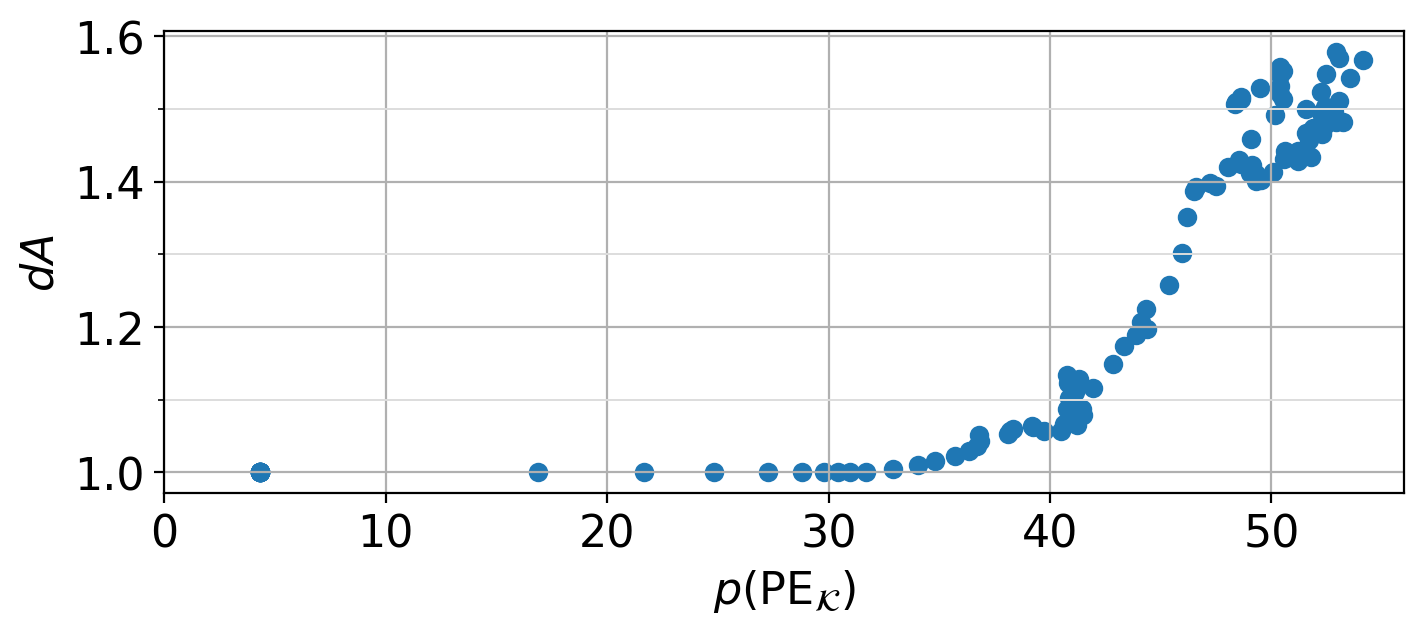

In [370]:
# based on the fitted GP model, you may see variations of the fake time
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(dpi=200, figsize=(8,3))
from matplotlib.ticker import MultipleLocator
plt.axes().yaxis.set_minor_locator(MultipleLocator(0.1))
plt.scatter(fake_time.detach(), torch.tensor(line)[RITVBO[0]['outcome_X'][:,-1].long()])
plt.xlabel('$p(\mathrm{PE}_\mathcal{K})$')
plt.ylabel('$dA$')
plt.xlim([0,56])
plt.grid()
plt.grid(which='minor', color='#DDDDDD', linewidth=0.7)
plt.show()

In [388]:
import pickle
with open('fake_time.pkl', 'wb') as fp:
    pickle.dump(fake_time.detach(), fp)

/var/folders/xl/2k7fxsd176n4d7pm2_k1v01w0000gn/T/ipykernel_95536/3094031729.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  axs[count].plot(range(1, len(pos_emb_res_array_Y_np.mean(0))+1),


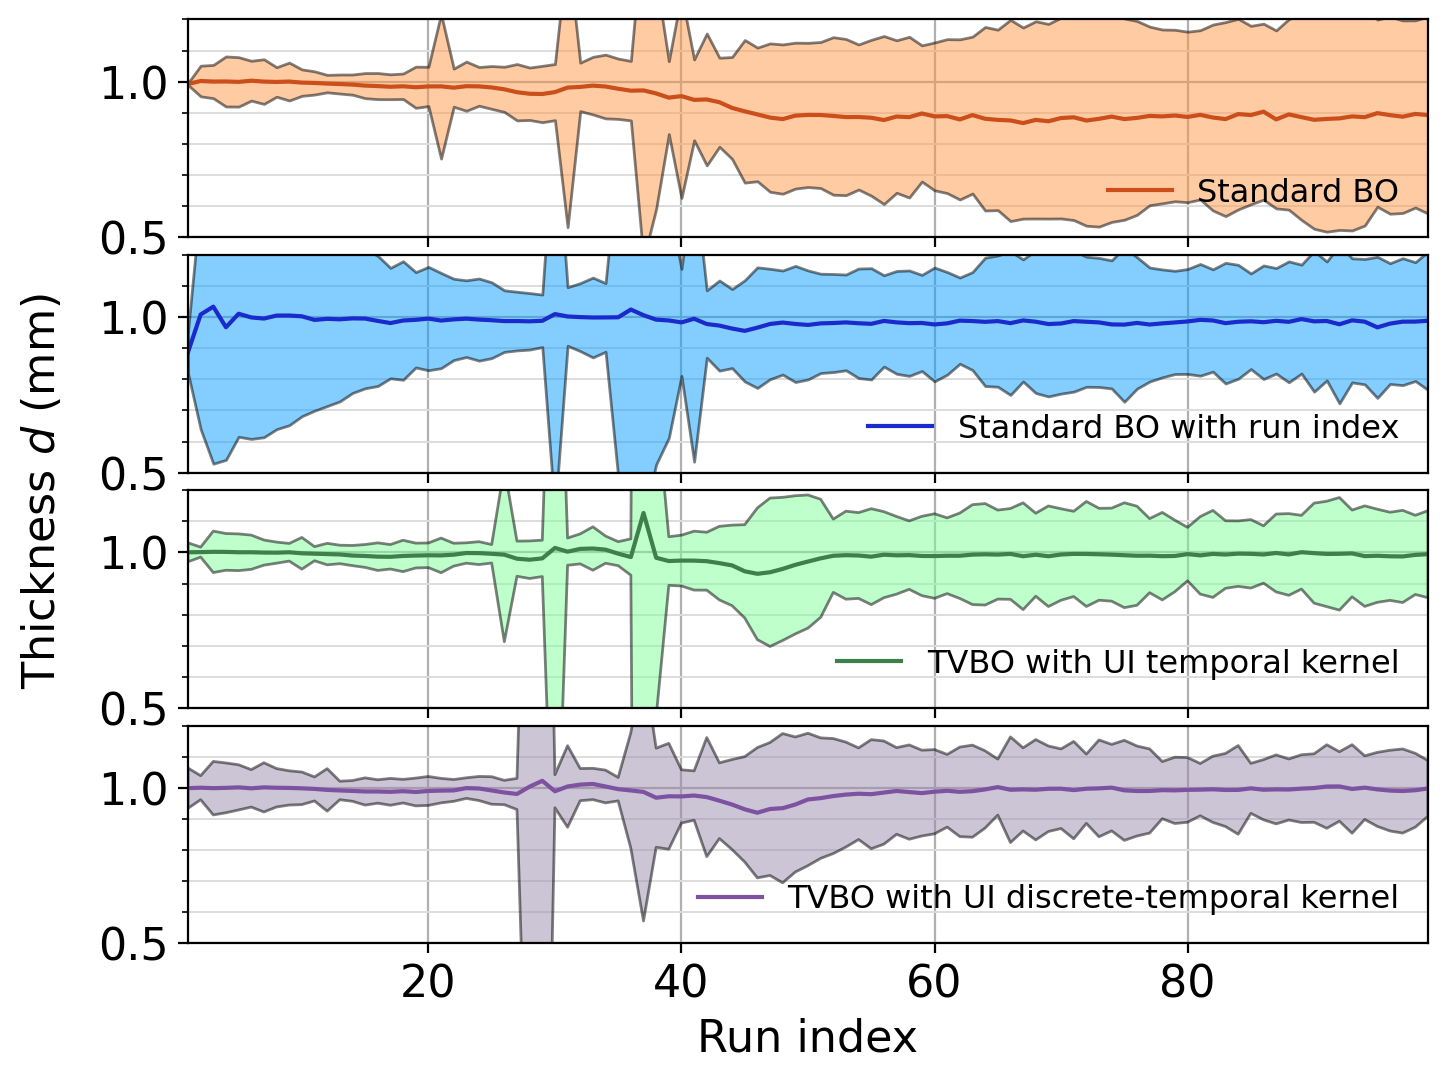

In [18]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

res = ["case3_BO.pkl", "case3_BOID.pkl", "case3_TVBO.pkl", "case3_TVBOpos_64.pkl"]
p_c = ['#CC4F1B', '#1B2ACC', '#3F7F4C', '#7D52A0']
f_c = ['#FF9848', '#089FFF', '#7EFF99', '#9B8CAE']
labels = ['Standard BO',
          'Standard BO with run index', 
          'TVBO with UI temporal kernel', 
          'TVBO with UI discrete-temporal kernel']
count = 0
fig = plt.figure(dpi=200, figsize=(8,6))
gs = fig.add_gridspec(4, hspace=0.08)
axs = gs.subplots(sharex=True, sharey=True)
for r in res:
    check = pickle.load(open(r, 'rb'))
    pos_emb_res_array_Y = torch.tensor([check[_]['outcome_Y'].tolist() for _ in range(256)]).squeeze(-1)
    pos_emb_res_array_Y_np = pos_emb_res_array_Y[:, 10:].numpy()
    axs[count].plot(range(1, len(pos_emb_res_array_Y_np.mean(0))+1), 
             pos_emb_res_array_Y_np.mean(0), 
             'k',
             label=labels[count],
             color=p_c[count])
    axs[count].fill_between(range(1, len(pos_emb_res_array_Y_np.mean(0))+1), 
                     pos_emb_res_array_Y_np.mean(0)-3*np.sqrt(pos_emb_res_array_Y_np.var(0)),
                     pos_emb_res_array_Y_np.mean(0)+3*np.sqrt(pos_emb_res_array_Y_np.var(0)),
                     alpha=0.5, edgecolor='k', facecolor=f_c[count])
    axs[count].set_ylim([0.5, 1.2])
    axs[count].set_xlim([1,99])
    axs[count].legend(frameon=False, loc='lower right', fontsize=11.5)
    from matplotlib.ticker import MultipleLocator
    axs[count].yaxis.set_minor_locator(MultipleLocator(0.1))
    if count == 2:
        axs[count].set_ylabel('Thickness $d$ (mm)')
        axs[count].yaxis.set_label_coords(-0.1, 1.)
    if count == 3:
        axs[count].set_xlabel('Run index')
    axs[count].grid()
    axs[count].grid(which='minor', color='#DDDDDD', linewidth=0.7)
    axs[count].set_axisbelow(True)
    count += 1


/var/folders/xl/2k7fxsd176n4d7pm2_k1v01w0000gn/T/ipykernel_95536/3149285602.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  axs[count].plot(range(1, len(pos_emb_res_array_Y_np.mean(0))+1),


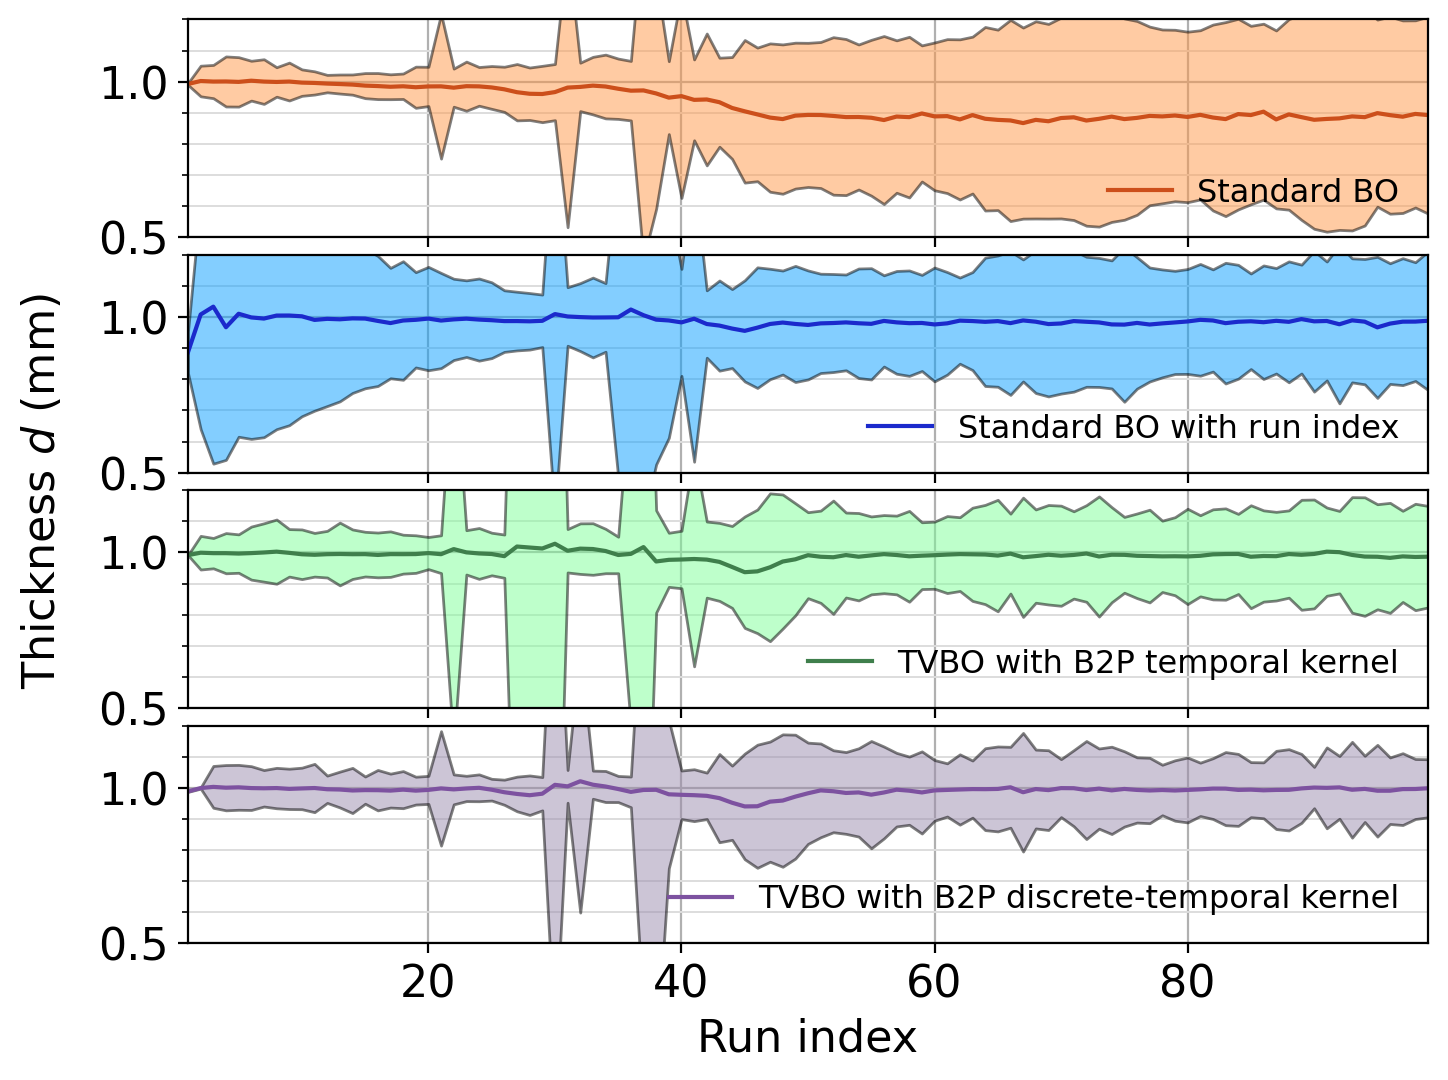

In [20]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

res = ["case3_BO.pkl", "case3_BOID.pkl", "case3_B2P.pkl", "case3_B2Ppos_64.pkl"]
p_c = ['#CC4F1B', '#1B2ACC', '#3F7F4C', '#7D52A0']
f_c = ['#FF9848', '#089FFF', '#7EFF99', '#9B8CAE']
labels = ['Standard BO',
          'Standard BO with run index', 
          'TVBO with B2P temporal kernel', 
          'TVBO with B2P discrete-temporal kernel']
count = 0
fig = plt.figure(dpi=200, figsize=(8,6))
gs = fig.add_gridspec(4, hspace=0.08)
axs = gs.subplots(sharex=True, sharey=True)
for r in res:
    check = pickle.load(open(r, 'rb'))
    pos_emb_res_array_Y = torch.tensor([check[_]['outcome_Y'].tolist() for _ in range(256)]).squeeze(-1)
    pos_emb_res_array_Y_np = pos_emb_res_array_Y[:, 10:].numpy()
    axs[count].plot(range(1, len(pos_emb_res_array_Y_np.mean(0))+1), 
             pos_emb_res_array_Y_np.mean(0), 
             'k',
             label=labels[count],
             color=p_c[count])
    axs[count].fill_between(range(1, len(pos_emb_res_array_Y_np.mean(0))+1), 
                     pos_emb_res_array_Y_np.mean(0)-3*np.sqrt(pos_emb_res_array_Y_np.var(0)),
                     pos_emb_res_array_Y_np.mean(0)+3*np.sqrt(pos_emb_res_array_Y_np.var(0)),
                     alpha=0.5, edgecolor='k', facecolor=f_c[count])
    axs[count].set_ylim([0.5, 1.2])
    axs[count].set_xlim([1,99])
    axs[count].legend(frameon=False, loc='lower right', fontsize=11.5)
    from matplotlib.ticker import MultipleLocator
    axs[count].yaxis.set_minor_locator(MultipleLocator(0.1))
    if count == 2:
        axs[count].set_ylabel('Thickness $d$ (mm)')
        axs[count].yaxis.set_label_coords(-0.1, 1.)
    if count == 3:
        axs[count].set_xlabel('Run index')
    axs[count].grid()
    axs[count].grid(which='minor', color='#DDDDDD', linewidth=0.7)
    axs[count].set_axisbelow(True)
    count += 1
